/home/steinbac/software/tifffile/0.8/python3/lib64/python3.4/site-packages/tifffile-0.8.0-py3.4-linux-x86_64.egg/tifffile/tifffile.py:263: UserWarning: failed to import the optional _tifffile C extension module.
Loading of some compressed images will be very slow.
Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "failed to import the optional _tifffile C extension module.\n"


(108, 1352, 532) (92, 1024, 512)


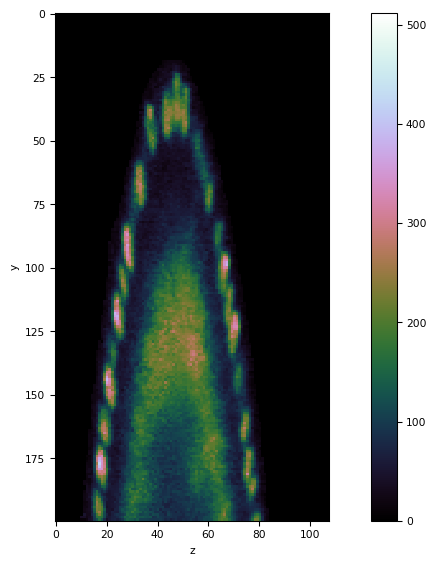

In [1]:
%matplotlib inline
import tifffile
import blosc
import numpy as np

blosc.set_nthreads(4)

royer1 = "/scratch/steinbac/sqeasy_data/xwing/droso-royer-may31-000005.tif"
xwingr = tifffile.imread(royer1)

haase1 = "/scratch/steinbac/sqeasy_data/xwing/000195-rhaase-20171129-fused-512x1024x92.tif"
xwingh = tifffile.imread(haase1)

smallr = xwingr[:,:200,:]
smallh = xwingh[:,:200,:]

sizes = {"smallr" : len(smallr.tobytes()), "smallh" : len(smallh.tobytes())}
print(xwingr.shape,xwingh.shape)
ax = tifffile.imshow(smallr[:,:,int(smallr.shape[-1]/2)].T)
ax[1].set_xlabel("z")
ax[1].set_ylabel("y")

# study of frame shuffle

- reorder frames along z along rising mean/median

[2865, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6940, 49714, 99172, 150150, 247105, 375301, 648935, 935031, 1221954, 1487598, 1738130, 1916082, 2092605, 2250243, 2450361, 2612096, 2757928, 2900634, 3083528, 3277875, 3521408, 3748280, 3933743, 4103050, 4340527, 4600448, 4746183, 4780420, 4831808, 5039091, 5166436, 5166543, 5221746, 5409205, 5446784, 5439458, 5477655, 5483086, 5482741, 5426836, 5355493, 5364505, 5397645, 5288527, 5159717, 5131459, 4997322, 4836599, 4701420, 4492946, 4290269, 4075769, 3803567, 3554693, 3302721, 3070219, 2833215, 2652987, 2445924, 2311124, 2154511, 1998298, 1859291, 1719875, 1599982, 1357305, 1091857, 799841, 532955, 332461, 202575, 107325, 69148, 17770, 81, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 81, 2865, 6940, 17770, 49714, 69148, 99172, 107325, 150150, 202575, 247105, 332461, 375301, 532955, 648935, 799841, 935031, 1091857, 1221954, 1357305, 

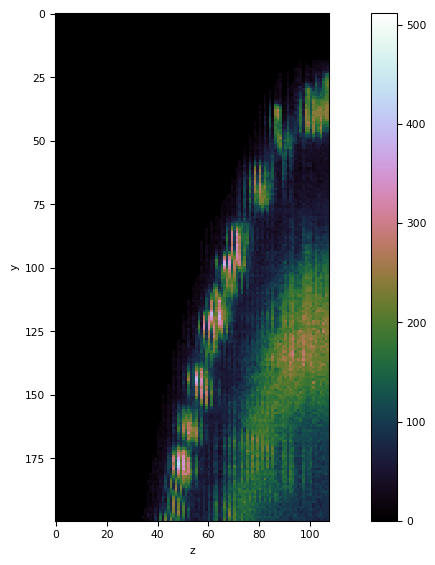

In [2]:
def frame_shuffle(_data):
    
    if len(_data.shape) != 3:
        print("data is not 3D!")
        return _data
    
    mv = []
    
    for z in range(_data.shape[0]):
        mv.append(np.sum(_data[z,:,:]))

    sorted_mv = sorted(mv)
    print(mv)
    print(sorted_mv)
    value = np.zeros_like(_data)
    
    assert len(mv) == _data.shape[0]
    
    for z in range(_data.shape[0]):
        src_index = mv.index(sorted_mv[z])
        value[z,:,:] = _data[src_index,:,:]
        
    return value

sorted_smallr = frame_shuffle(smallr)
sorted_smallh = frame_shuffle(smallh)

ax = tifffile.imshow(sorted_smallr[:,:,int(sorted_smallr.shape[-1]/2)].T)
ax[1].set_xlabel("z")
ax[1].set_ylabel("y")

In [3]:
import math
import time

strd = {blosc.BITSHUFFLE : "bitshuffle", blosc.NOSHUFFLE : "none", None : "none" , blosc.SHUFFLE : "byteshuffle"}

def compress_list(datum,shufflemode = blosc.BITSHUFFLE, clevel = 5, engine="lz4"):
    
          
    start = time.time()
    compressed = blosc.compress(datum.tobytes(),shuffle=shufflemode,clevel=clevel,cname=engine)
    end = time.time()   
    value = ((len(datum.tobytes()),len(compressed),end-start,"%s-%i-%s" % (engine,clevel,strd[shufflemode])))
    return value

bitshuffled_nbytes = {}
bitshuffled_nbytes["smallr"] = compress_list(smallr)
bitshuffled_nbytes["smallh"] = compress_list(smallh)
bitshuffled_nbytes["smallr_sorted"] = compress_list(sorted_smallr)
bitshuffled_nbytes["smallh_sorted"] = compress_list(sorted_smallh)
bitshuffled_nbytes["smallr-8"] = compress_list(smallr,clevel=8)
bitshuffled_nbytes["smallh-8"] = compress_list(smallh,clevel=8)
bitshuffled_nbytes["smallr_sorted-8"] = compress_list(sorted_smallr,clevel=8)
bitshuffled_nbytes["smallh_sorted-8"] = compress_list(sorted_smallh,clevel=8)
bitshuffled_nbytes["smallr-2"] = compress_list(smallr,clevel=2)
bitshuffled_nbytes["smallh-2"] = compress_list(smallh,clevel=2)
bitshuffled_nbytes["smallr_sorted-2"] = compress_list(sorted_smallr,clevel=2)
bitshuffled_nbytes["smallh_sorted-2"] = compress_list(sorted_smallh,clevel=2)


In [4]:
def summary(cdic):
    print("%20s %20s %10s %10s %8s %10s"%("","info","inbytes","outbytes","ratio", "bw [MB/s]"))
    for (k,item) in cdic.items():
        
        ratio = item[0]/item[1]
        bw = item[0]/(1024.*1024.*item[2])
        print("%20s %20s %10i %10i %8.2f %10.2f" % (k,item[-1],item[0],item[1],ratio,bw))
            
summary(bitshuffled_nbytes)

                                     info    inbytes   outbytes    ratio  bw [MB/s]
              smallr     lz4-5-bitshuffle   22982400    3789107     6.07     187.35
              smallh     lz4-5-bitshuffle   18841600    4464109     4.22     200.54
       smallr_sorted     lz4-5-bitshuffle   22982400    3789225     6.07     595.65
       smallh_sorted     lz4-5-bitshuffle   18841600    4465409     4.22     519.44
            smallr-8     lz4-8-bitshuffle   22982400    3647688     6.30     211.46
            smallh-8     lz4-8-bitshuffle   18841600    4362905     4.32     199.15
     smallr_sorted-8     lz4-8-bitshuffle   22982400    3647214     6.30     557.51
     smallh_sorted-8     lz4-8-bitshuffle   18841600    4363328     4.32     488.98
            smallr-2     lz4-2-bitshuffle   22982400    4007329     5.74     207.33
            smallh-2     lz4-2-bitshuffle   18841600    4608407     4.09     180.04
     smallr_sorted-2     lz4-2-bitshuffle   22982400    4007171     5.74    

In [4]:
def frame_shuffle_median(_data):
    
    if len(_data.shape) != 3:
        print("data is not 3D!")
        return _data
    
    mv = []
    
    for z in range(_data.shape[0]):
        mv.append(np.percentile(_data[z,:,:],q=75.))

    sorted_mv = sorted(mv)
    print(mv)
    print(sorted_mv)
    value = np.zeros_like(_data)
    
    assert len(mv) == _data.shape[0]
    
    for z in range(_data.shape[0]):
        src_index = mv.index(sorted_mv[z])
        value[z,:,:] = _data[src_index,:,:]
        
    return value

medsorted_smallr = frame_shuffle_median(smallr)
medsorted_smallh = frame_shuffle_median(smallh)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 5.0, 7.0, 8.0, 9.0, 11.0, 13.0, 16.0, 19.0, 25.0, 33.0, 38.0, 42.0, 46.0, 47.0, 52.0, 56.0, 58.0, 59.0, 62.0, 65.0, 68.0, 71.0, 74.0, 79.0, 82.0, 84.0, 86.0, 88.0, 90.0, 86.0, 85.0, 86.0, 82.0, 77.0, 74.0, 69.0, 67.0, 64.0, 59.0, 57.0, 53.0, 49.0, 43.0, 36.0, 26.0, 20.0, 15.0, 13.0, 11.0, 9.0, 8.0, 7.0, 6.0, 5.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 3.0, 5.0, 5.0, 6.0, 7.0, 7.0, 8.0, 8.0, 9.0, 9.0, 11.0, 11.0, 13.0, 13.0, 15.0, 16.0, 19.0, 20.0, 25.0, 26.0, 33.0, 36.0, 38.0, 42.0, 43.0, 46.0, 47

In [5]:

median_bitshuffled_nbytes = {}
median_bitshuffled_nbytes["smallr"] = compress_list(smallr)
median_bitshuffled_nbytes["smallh"] = compress_list(smallh)
median_bitshuffled_nbytes["smallr_sorted"] = compress_list(medsorted_smallr)
median_bitshuffled_nbytes["smallh_sorted"] = compress_list(medsorted_smallh)
median_bitshuffled_nbytes["smallr-8"] = compress_list(smallr,clevel=8)
median_bitshuffled_nbytes["smallh-8"] = compress_list(smallh,clevel=8)
median_bitshuffled_nbytes["smallr_sorted-8"] = compress_list(medsorted_smallr,clevel=8)
median_bitshuffled_nbytes["smallh_sorted-8"] = compress_list(medsorted_smallh,clevel=8)
median_bitshuffled_nbytes["smallr-2"] = compress_list(smallr,clevel=2)
median_bitshuffled_nbytes["smallh-2"] = compress_list(smallh,clevel=2)
median_bitshuffled_nbytes["smallr_sorted-2"] = compress_list(medsorted_smallr,clevel=2)
median_bitshuffled_nbytes["smallh_sorted-2"] = compress_list(medsorted_smallh,clevel=2)

In [50]:
summary(median_bitshuffled_nbytes)

                                     info    inbytes   outbytes    ratio  bw [MB/s]
              smallr     lz4-5-bitshuffle   22982400    3789107     6.07     174.20
              smallh     lz4-5-bitshuffle   18841600    4464109     4.22     198.63
       smallr_sorted     lz4-5-bitshuffle   22982400    3538747     6.49     545.05
       smallh_sorted     lz4-5-bitshuffle   18841600    4329345     4.35     515.20
            smallr-8     lz4-8-bitshuffle   22982400    3647688     6.30     211.69
            smallh-8     lz4-8-bitshuffle   18841600    4362905     4.32     193.26
     smallr_sorted-8     lz4-8-bitshuffle   22982400    3404038     6.75     589.64
     smallh_sorted-8     lz4-8-bitshuffle   18841600    4238127     4.45     511.24
            smallr-2     lz4-2-bitshuffle   22982400    4007329     5.74     218.13
            smallh-2     lz4-2-bitshuffle   18841600    4608407     4.09     207.06
     smallr_sorted-2     lz4-2-bitshuffle   22982400    3738046     6.15    

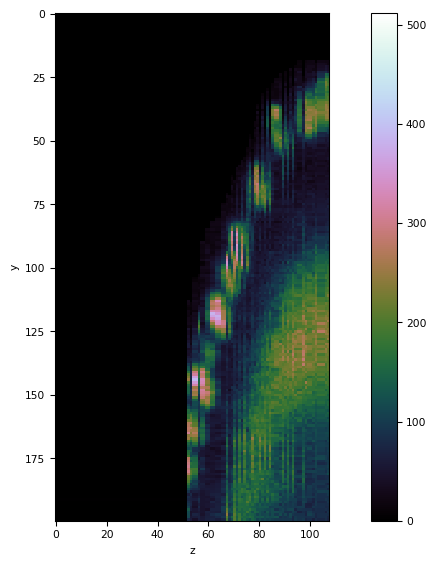

In [6]:
ax = tifffile.imshow(medsorted_smallr[:,:,int(medsorted_smallr.shape[-1]/2)].T)
ax[1].set_xlabel("z")
ax[1].set_ylabel("y")